In [ ]:
!pip install -q astred[spacy]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 2.4 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving velhos-apedidos-e-velhos-anúncios_st_ht.align.json to velhos-apedidos-e-velhos-anúncios_st_ht.align.json
Saving o-nosso-feminism_st_ht.align.json to o-nosso-feminism_st_ht.align.json
Saving o-nosso-feminism_st_mt.align.json to o-nosso-feminism_st_mt.align.json
Saving o-pavilhão-e-a-pinel_mt_pemt.align.json to o-pavilhão-e-a-pinel_mt_pemt.align.json
Saving o-pavilhão-e-a-pinel_st_mt.align.json to o-pavilhão-e-a-pinel_st_mt.align.json
Saving o-pavilhão-e-a-pinel_st_pemt.align.json to o-pavilhão-e-a-pinel_st_pemt.align.json
Saving papel-moeda_mt_ht.align.json to papel-moeda_mt_ht.align.json
Saving papel-moeda_st_ht.align.json to papel-moeda_st_ht.align.json
Saving papel-moeda_st_mt.align.json to papel-moeda_st_mt.align.json
Saving qualquer-serve_mt_ht.align.json to qualquer-serve_mt_ht.align.json
Saving qualquer-serve_st_ht.align.json to qualquer-serve_st_ht.align.json
Saving qualquer-serve_st_mt.align.json to qualquer-serve_st_mt.align.json
Saving uma-anedota_mt_ht.align.json to u

In [ ]:
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 69.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 50.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from astred.utils import load_parser

nlp_de = load_parser("de_core_news_sm", "spacy")
nlp_pt = load_parser("pt_core_news_sm", "spacy")

In [ ]:
import json
from astred import Word, AlignedSentences, Sentence
import glob
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import re
import numpy as np
import unicodedata

In [ ]:
# Save uploaded files to disk so we can read them normally
for name, content in uploaded.items():
    with open(name, 'wb') as f:
        f.write(content)

In [ ]:
def convert_heads_1_to_0(heads_1_based):
    # Convert 1-based heads to 0-based, root = 0
    return [h - 1 if h > 0 else 0 for h in heads_1_based]

In [ ]:
from astred import Word
help(Word.__init__)

Help on function __init__ in module astred.word:

__init__(self, id: 'int', doc: 'Sentence' = None, is_null: 'bool' = False, text: 'str' = None, lemma: 'str' = None, head: 'int' = None, deprel: 'str' = None, upos: 'str' = None, xpos: 'str' = None, feats: 'str' = None, _word: 'Any' = None) -> None
    Initialize self.  See help(type(self)) for accurate signature.



In [ ]:
def convert_to_sentence(word_data):
    words = []
    tokens = word_data['tokens']
    pos_tags = word_data['pos']
    deprels = word_data['deprels']
    heads_0 = word_data['heads_0_based']  # 0-based heads, -1 means root

    for i, (token, pos, deprel, head) in enumerate(zip(tokens, pos_tags, deprels, heads_0)):
        head_1based = 0 if head == -1 else head + 1  # root = 0, else convert 0-based to 1-based
        w = Word(id=i+1, text=token, upos=pos, deprel=deprel, head=head_1based)
        words.append(w)
    return Sentence(words)

In [ ]:
def process_file(filename, strategy='inter'):
    with open(filename, 'r', encoding='utf-8') as f:
        data = json.load(f)

    aligned_sentences = []
    for item in data:
        src_sentence = convert_to_sentence(item['src'])
        tgt_sentence = convert_to_sentence(item['tgt'])

        alignment = item['alignments'][strategy]

        aligned_sent = AlignedSentences(src_sentence, tgt_sentence, alignment)
        aligned_sentences.append(aligned_sent)

    return aligned_sentences

In [ ]:
ALIGN_DIR = '/content/'  # Adjust if needed
ALIGN_STRATEGY = 'inter'  # Choose your alignment strategy here

results_per_text = defaultdict(dict)
similarities_per_text = defaultdict(lambda: defaultdict(list))

for filename in sorted(glob.glob(ALIGN_DIR + '*.align.json')):
    aligned_sents = process_file(filename)

    total_ted = 0
    count = 0
    skipped_sim_count = 0  # ✅ moved outside loop

    fname = os.path.basename(filename)
    match = re.match(r'(.+?)_(st|mt)_(ht|mt|pemt)\.align\.json$', fname)
    if not match:
        continue
    base_name, src, tgt = match.groups()
    tgt = 'ht' if tgt == 'pemt' else tgt
    pair_type = f"{src}_{tgt}"

    for aligned in aligned_sents:
        src_sent = aligned.src
        tgt_sent = aligned.tgt
        total_ted += aligned.ted
        count += 1

        if src_sent._sentence and tgt_sent._sentence:
            sim = src_sent._sentence.similarity(tgt_sent._sentence)
            similarities_per_text[base_name][pair_type].append(sim)
        else:
            skipped_sim_count += 1

    print(f"{fname}: Skipped {skipped_sim_count} sentence pairs due to missing parse trees.")

    avg_ted = total_ted / count if count else 0
    sims = similarities_per_text[base_name][pair_type]
    avg_similarity = sum(sims) / len(sims) if sims else 0

    results_per_text[base_name][pair_type] = avg_ted
    similarities_per_text[base_name][pair_type] = avg_similarity

# Sort text titles
sorted_texts = sorted(results_per_text.keys())

# Extract ASTrED values per translation pair type
st_mt_vals = [results_per_text[title].get('st_mt', None) for title in sorted_texts]
st_ht_vals = [results_per_text[title].get('st_ht', None) for title in sorted_texts]
mt_ht_vals = [results_per_text[title].get('mt_ht', None) for title in sorted_texts]

18-Sep 15:55:17 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.


a-cartomante_mt_ht.align.json: Skipped 199 sentence pairs due to missing parse trees.


18-Sep 15:55:29 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.


a-cartomante_st_ht.align.json: Skipped 199 sentence pairs due to missing parse trees.


18-Sep 15:55:31 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.
18-Sep 15:55:33 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.


a-cartomante_st_mt.align.json: Skipped 199 sentence pairs due to missing parse trees.
a-lei_mt_ht.align.json: Skipped 13 sentence pairs due to missing parse trees.
a-lei_st_ht.align.json: Skipped 13 sentence pairs due to missing parse trees.
a-lei_st_mt.align.json: Skipped 13 sentence pairs due to missing parse trees.
a-questão-dos-telefones_mt_ht.align.json: Skipped 29 sentence pairs due to missing parse trees.
a-questão-dos-telefones_st_ht.align.json: Skipped 29 sentence pairs due to missing parse trees.
a-questão-dos-telefones_st_mt.align.json: Skipped 29 sentence pairs due to missing parse trees.
a-volta_mt_ht.align.json: Skipped 10 sentence pairs due to missing parse trees.
a-volta_st_ht.align.json: Skipped 10 sentence pairs due to missing parse trees.
a-volta_st_mt.align.json: Skipped 10 sentence pairs due to missing parse trees.
as-vaporosas_mt_ht.align.json: Skipped 19 sentence pairs due to missing parse trees.
as-vaporosas_st_ht.align.json: Skipped 19 sentence pairs due to mis

18-Sep 15:55:42 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.


cada-raça-tem-um-calino_mt_ht.align.json: Skipped 83 sentence pairs due to missing parse trees.


18-Sep 15:55:44 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.
18-Sep 15:55:45 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.


cada-raça-tem-um-calino_st_ht.align.json: Skipped 83 sentence pairs due to missing parse trees.


18-Sep 15:55:47 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.


cada-raça-tem-um-calino_st_mt.align.json: Skipped 83 sentence pairs due to missing parse trees.
efeitos-da-lei-valetudinária_mt_ht.align.json: Skipped 26 sentence pairs due to missing parse trees.
efeitos-da-lei-valetudinária_st_ht.align.json: Skipped 26 sentence pairs due to missing parse trees.
efeitos-da-lei-valetudinária_st_mt.align.json: Skipped 26 sentence pairs due to missing parse trees.
exemplo-a-imitar_mt_ht.align.json: Skipped 18 sentence pairs due to missing parse trees.
exemplo-a-imitar_st_ht.align.json: Skipped 18 sentence pairs due to missing parse trees.
exemplo-a-imitar_st_mt.align.json: Skipped 18 sentence pairs due to missing parse trees.
fala-o-corvo_mt_ht.align.json: Skipped 27 sentence pairs due to missing parse trees.
fala-o-corvo_st_ht.align.json: Skipped 27 sentence pairs due to missing parse trees.
fala-o-corvo_st_mt.align.json: Skipped 27 sentence pairs due to missing parse trees.


18-Sep 15:55:55 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.


linhas-de-tiro_mt_ht.align.json: Skipped 24 sentence pairs due to missing parse trees.


18-Sep 15:55:56 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.


linhas-de-tiro_st_ht.align.json: Skipped 24 sentence pairs due to missing parse trees.
linhas-de-tiro_st_mt.align.json: Skipped 24 sentence pairs due to missing parse trees.
modas-femininas-e-outras_mt_ht.align.json: Skipped 16 sentence pairs due to missing parse trees.
modas-femininas-e-outras_st_ht.align.json: Skipped 16 sentence pairs due to missing parse trees.
modas-femininas-e-outras_st_mt.align.json: Skipped 16 sentence pairs due to missing parse trees.
no-primor-da-elegância_mt_ht.align.json: Skipped 132 sentence pairs due to missing parse trees.
no-primor-da-elegância_st_ht.align.json: Skipped 132 sentence pairs due to missing parse trees.
no-primor-da-elegância_st_mt.align.json: Skipped 132 sentence pairs due to missing parse trees.
não-as-matem_mt_ht.align.json: Skipped 20 sentence pairs due to missing parse trees.
não-as-matem_st_ht.align.json: Skipped 20 sentence pairs due to missing parse trees.
não-as-matem_st_mt.align.json: Skipped 20 sentence pairs due to missing parse

18-Sep 15:56:37 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.


qualquer-serve_mt_ht.align.json: Skipped 30 sentence pairs due to missing parse trees.
qualquer-serve_st_ht.align.json: Skipped 30 sentence pairs due to missing parse trees.


18-Sep 15:56:38 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.


qualquer-serve_st_mt.align.json: Skipped 30 sentence pairs due to missing parse trees.
uma-anedota_mt_ht.align.json: Skipped 30 sentence pairs due to missing parse trees.
uma-anedota_st_ht.align.json: Skipped 30 sentence pairs due to missing parse trees.
uma-anedota_st_mt.align.json: Skipped 30 sentence pairs due to missing parse trees.


18-Sep 15:56:40 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.
18-Sep 15:56:40 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.
18-Sep 15:56:40 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.
18-Sep 15:56:40 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.


uma-lembrança_mt_ht.align.json: Skipped 21 sentence pairs due to missing parse trees.


18-Sep 15:56:40 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.
18-Sep 15:56:40 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.


uma-lembrança_st_ht.align.json: Skipped 21 sentence pairs due to missing parse trees.


18-Sep 15:56:40 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.
18-Sep 15:56:41 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.


uma-lembrança_st_mt.align.json: Skipped 21 sentence pairs due to missing parse trees.
uma-outra_mt_ht.align.json: Skipped 53 sentence pairs due to missing parse trees.
uma-outra_st_ht.align.json: Skipped 53 sentence pairs due to missing parse trees.
uma-outra_st_mt.align.json: Skipped 53 sentence pairs due to missing parse trees.
uma-partida-de-football_mt_ht.align.json: Skipped 16 sentence pairs due to missing parse trees.
uma-partida-de-football_st_ht.align.json: Skipped 16 sentence pairs due to missing parse trees.
uma-partida-de-football_st_mt.align.json: Skipped 16 sentence pairs due to missing parse trees.
velhos-apedidos-e-velhos-anúncios_mt_ht.align.json: Skipped 100 sentence pairs due to missing parse trees.
velhos-apedidos-e-velhos-anúncios_st_ht.align.json: Skipped 100 sentence pairs due to missing parse trees.
velhos-apedidos-e-velhos-anúncios_st_mt.align.json: Skipped 100 sentence pairs due to missing parse trees.


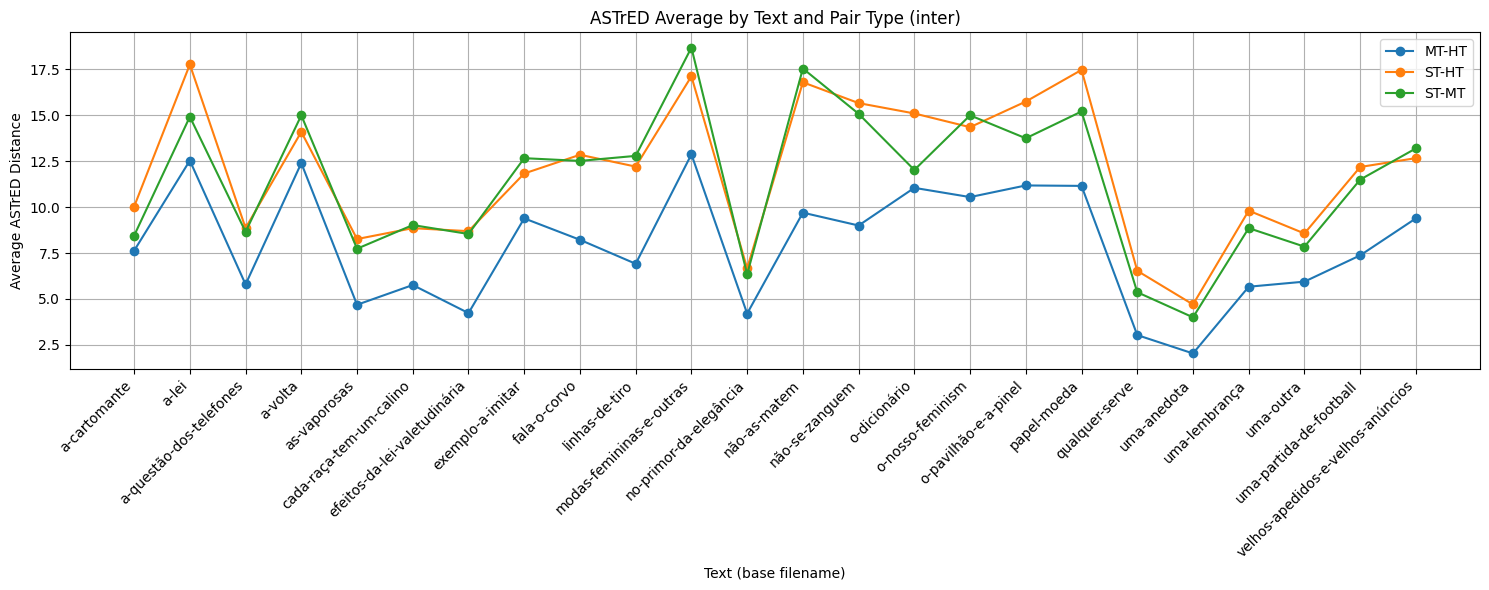

In [ ]:
x = np.arange(len(sorted_texts))

plt.figure(figsize=(15, 6))
plt.plot(x, mt_ht_vals, marker='o', label='MT-HT')
plt.plot(x, st_ht_vals, marker='o', label='ST-HT')
plt.plot(x, st_mt_vals, marker='o', label='ST-MT')

plt.xticks(x, sorted_texts, rotation=45, ha='right')
plt.xlabel('Text (base filename)')
plt.ylabel('Average ASTrED Distance')
plt.title(f'ASTrED Average by Text and Pair Type ({ALIGN_STRATEGY})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Compute overall ASTrED averages per dataset
avg_astred = {
    "MT–HT": np.mean([vals["mt_ht"] for vals in results_per_text.values() if "mt_ht" in vals]),
    "ST–MT": np.mean([vals["st_mt"] for vals in results_per_text.values() if "st_mt" in vals]),
    "ST–HT": np.mean([vals["st_ht"] for vals in results_per_text.values() if "st_ht" in vals]),
}

print("Average ASTrED values:")
for k, v in avg_astred.items():
    print(f"{k}: {v:.2f}")

Average ASTrED values:
MT–HT: 7.95
ST–MT: 11.45
ST–HT: 11.95


In [ ]:
# Print ASTrED results per text and pair type
print("ASTrED values per text:\n")
for title in sorted_texts:
    mt_ht_val = results_per_text[title].get("mt_ht", None)
    st_mt_val = results_per_text[title].get("st_mt", None)
    st_ht_val = results_per_text[title].get("st_ht", None)
    print(f"{title:33s}  MT–HT: {mt_ht_val:.2f}   ST–MT: {st_mt_val:.2f}   ST–HT: {st_ht_val:.2f}")

ASTrED values per text:

a-cartomante                       MT–HT: 7.63   ST–MT: 8.45   ST–HT: 10.03
a-lei                              MT–HT: 12.54   ST–MT: 14.92   ST–HT: 17.77
a-questão-dos-telefones            MT–HT: 5.79   ST–MT: 8.66   ST–HT: 8.86
a-volta                            MT–HT: 12.40   ST–MT: 15.00   ST–HT: 14.10
as-vaporosas                       MT–HT: 4.68   ST–MT: 7.74   ST–HT: 8.26
cada-raça-tem-um-calino            MT–HT: 5.76   ST–MT: 9.02   ST–HT: 8.86
efeitos-da-lei-valetudinária       MT–HT: 4.23   ST–MT: 8.54   ST–HT: 8.69
exemplo-a-imitar                   MT–HT: 9.39   ST–MT: 12.67   ST–HT: 11.83
fala-o-corvo                       MT–HT: 8.22   ST–MT: 12.52   ST–HT: 12.85
linhas-de-tiro                     MT–HT: 6.92   ST–MT: 12.79   ST–HT: 12.21
modas-femininas-e-outras           MT–HT: 12.88   ST–MT: 18.69   ST–HT: 17.12
no-primor-da-elegância             MT–HT: 4.20   ST–MT: 6.34   ST–HT: 6.67
não-as-matem                       MT–HT: 9.70   ST–MT: 17.